In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict 

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from tqdm import tqdm
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from tslearn.clustering import  TimeSeriesKMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score,f1_score

import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

## Helper Functions

#### Create Null Values

In [2]:
"""
We need to create NaNs and can be done in 3 methods using below funtions

1. Continous : Remove continous chunk of a specified size
2. Random : Randomly remove chunks of data of a specified size
3. Selectively: Removes 3 chunks of some size p1,p2,p3 such that p1,p2,p3,p1+p2+p3<perc and rest is removed randomly

The last method is to simulate real world cases.

Note (Very Important): It is necessary to create a copy of data as not creating copy actually removes data in the original variable.
Python arrays that are passed to function just passes the address to array and all operations are done on the 
original variable. Thus we use arr=data.copy() 
"""

def create_nans_consecutively(data,perc=0.10):
    data_missing=[]
    for n in range(len(data)):
        arr=data[n].copy()
        arr=arr.astype('float')
        loc=np.random.choice(np.arange(0,len(arr)*(1-perc)-1),size=1)[0]
        arr[int(loc):int(loc)+int(len(arr)*perc)] = -999
        arr[arr == -999] = np.nan
        data_missing.append(arr)
    return data_missing

def create_nans_randomly(data,perc=0.1):
    data_missing=[]
    missing_len=int(len(data[0])*perc)
    for n in range(len(data)):
        arr=data[n].copy()
        arr=arr.astype('float')
        for _ in range(int(missing_len)):
            ind=np.random.choice(np.arange(0,len(arr)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(arr)-1),size=1)[0]
            arr[ind]=np.nan    
        data_missing.append(arr)
    return data_missing

def create_nans_selectively(data,perc=0.1):
    data_missing=[]
    for n in range(len(data)):
        arr=data[n].copy()
        missing_len=int(len(arr)*perc)
        
        # Consecutively
        for i in range(3):
            temp_miss=int(np.random.choice(np.arange(0.1*missing_len/3,missing_len/3),size=1)[0])
            loc_st=int(np.random.choice(np.arange(len(arr)*i//3,len(arr)*(i+1)//3-temp_miss),size=1)[0])
            k=0
            while temp_miss!=k and loc_st<len(arr):
                if not pd.isnull(arr[loc_st]):
                    arr[loc_st]=np.nan
                    k+=1
                loc_st+=1
            missing_len-=k
        # Randomly
        for _ in range(missing_len):
            ind=np.random.choice(np.arange(0,len(arr)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(arr)-1),size=1)[0]
            arr[ind]=np.nan    
        data_missing.append(arr)
        
    return data_missing

#### Interpolation

In [3]:
def l_i(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def linear_interpolation(data):
    """
    Function for performing linear interpolation uses l_i
    """
    data_inter=[]
    for i in range(len(data)):
        interpolated_data = l_i(data[i])
        data_inter.append(interpolated_data)
    return data_inter



def knn_interpolation(data,n_neighbors_val=10):
    data_missing_imputed=[]
    for i in range(len(data)):
        k=data[i].copy()
        time=np.arange(1,len(k)+1,1)
        temp=pd.DataFrame({'time':time,'arr':k})
        knn=KNNImputer(n_neighbors=n_neighbors_val)
        imputed=pd.DataFrame(knn.fit_transform(np.array(temp)),columns=temp.columns)['arr'].values
        data_missing_imputed.append(imputed)        
    return data_missing_imputed


#### Scoring

In [4]:
def find_num(P,threshold):
    """
    This functions is used by our scoring function. and finds number of values that is greater than
    P[0]*threshold. 
    Eg: Our find_missing_block returns : [100,90,70,50,4,2,1], Let threshold=0.8
    so we count number of values >100*0.8
    we return 2
    """
    n=threshold*P[0]
    for i,val in enumerate(P):
        if val<n:
            return i
    return i+1

def find_missing_blocks(input_list):
    """
    This functions find chunks of missing values and returns it as an array.
    eg: [1,2,nan,3,4,nan,nan,nan,5,nan,nan,nan,nan,nan,4,nan,2] 
    (1,3,5,1) ---> NaNs sizes from lhs to rhs. ---> Descending order is returned
    Returns:[5,3,1,1]
    
    If no missing values returns:[0]
    """
    missing_blocks_len = []
    current_block = []

    for item in input_list:
        if pd.isnull(item):  # You can change this condition to match the type of missing value in your list
            current_block.append(item)
        elif current_block:
            missing_blocks_len.append(len(current_block))
            current_block = []

    if current_block:
        missing_blocks_len.append(len(current_block))
    missing_blocks_len.sort(reverse=True)

    if len(missing_blocks_len)==0:
        missing_blocks_len=[0]
    return missing_blocks_len


def score(P,l,t):
    """
    Custom Scoring Function
    We consider NaN % and mean contigous missing length(MCML) as our interpolation is bad as MCML increases.
    Our function returns a product of :
            i) NaN%
           ii) MCML
    If Score -->1 dataset is of good quality and -->0 it has a lot of missing values. 
    P: Array containing contiguous NaN's in descending order
    l : Length of array
    """
    n=find_num(P,t)
    e1= (1-sum(P)/l)
    if n==0:
        e2=1
        #warnings.simplefilter("default")
        if t>1:
            warnings.warn("Looks like Threshold>1, So Score returned is just nan %")  
    else:
        e2= (1-np.mean(P[:n])/l)
    return round(e1*e2,4)


def find_score_data(data,threshold=0.75,to_print=False,return_avg=True):
    s=[]
    for i in range(len(data)):
        arr_missing=find_missing_blocks(data[i])
        s.append(score(arr_missing,len(data[0]),threshold))
    if to_print is True:
        print(s)
    if return_avg:
        return np.average(s)
    return s


def rmse_data(true,pred):
    return np.sqrt(1/len(true)*np.sum(np.square((true-pred))))

#### Clustering

In [5]:
def map_kmeans_to_true_labels(kmeans_labels, true_labels):
    """
    K Means Clustering produces a set of labels (eg Class X Y Z)
    We may have labels as Class A,B,C. So we need to map them. 
    We map them on basis frequency. If class X has more of A then we assign it class A and so on...
    """
    label_mapping = {}
    unique_kmeans_labels = np.unique(kmeans_labels)
    for kmeans_label in unique_kmeans_labels:
        cluster_indices = np.where(kmeans_labels == kmeans_label)[0]
        true_label_counts = defaultdict(int)
        for index in cluster_indices:
            true_label = true_labels[index]
            true_label_counts[true_label] += 1
        most_common_true_label = max(true_label_counts, key=true_label_counts.get)
        label_mapping[kmeans_label] = most_common_true_label
    pred_transformed = [label_mapping.get(element, np.nan) for element in kmeans_labels]
    return pred_transformed

colors=['violet','greenyellow','skyblue','khaki','crimson'] # Colors to help us plot the graphs

def kMeans_timeseries(data,data_labels,times_init_centroid=2,to_plot=True,to_print=True):
    """
    K Means TimeSeries Clustering using DTW as distance metric
    n_init : Important Parameter as it determines number of times the initialisation is done. This step is very
    important for some initialisation of centroid solution maynot converge and we may get very bad results. 
    Default value is 1. Better to set it to a higher value but computation time increases.
    
    Output: We return a dataframe consisting of Series Number, Original Label and Predicted Label 

    to_print: Set this to True if you want to print clustering algorithm's evaluation metrics like confusion matrix
    NMI, ARI and Rand Index

    Number of clusters is assumed to be known and uses total number of unique label classes as n_cluster

    """
    n_clusters = len(pd.DataFrame(data_labels)[0].unique())

    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42,n_init=times_init_centroid,n_jobs=10)
    kmeans.fit(data)

    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    clus_centers=cluster_centers.reshape(n_clusters,-1)


    cluster_labels_predicted=map_kmeans_to_true_labels(cluster_assignments,data_labels)
    series_number=['Series_'+str(i+1) for i in range(len(data))]
    df=pd.DataFrame({'Series_No':series_number,'labels':data_labels,'Predicted_labels':cluster_labels_predicted})


    if to_print:

        confusion = confusion_matrix(data_labels, cluster_labels_predicted)
        print("-------------------------------------------")
        print("Confusion Matrix:")
        print(confusion)

        nmi = normalized_mutual_info_score(data_labels, cluster_labels_predicted)
        print("Normalized Mutual Information (NMI):", nmi)

        ari = adjusted_rand_score(data_labels, cluster_labels_predicted)
        print("Adjusted Rand Index (ARI):", ari)


        f1 = f1_score(data_labels, cluster_labels_predicted,average='macro')
        print("F1 Score:", f1)
        
    if to_plot:
        data=pd.DataFrame(data)
        data['labels']=data_labels
        # Sorting so that plotting can be easier
        data.sort_values(by='labels',inplace=True)
        data.reset_index(drop=True)

        fig = go.Figure()
       
        group_names=['Group_'+str(i+1) for i in range(n_clusters)]
        k=-1
        for ind,row in data.iterrows():
            if k!=row['labels']:
                k=row['labels']
                j=0
            fig.add_trace(go.Scatter(x=np.arange(len(row)-1),y=row[:-1], mode='lines', line=dict(color=colors[int(k)]), name=group_names[int(k)],legendgroup=group_names[int(k)],showlegend=(j==0)))
            j+=1

        # Plot cluster centers with different line styles
        colors_clusters = ['black', 'darkblue', 'darkred', 'darkgreen', 'maroon', 'darkslategrey']
        for i in range(n_clusters):
            fig.add_trace(go.Scatter(x=np.arange(len(clus_centers[i])), y=clus_centers[i], mode='lines', line=dict(color=colors_clusters[i]), name=f'C_{i+1}', line_shape='linear'))  
        fig.show()
    
    return df

## Pre Processing Data

In [6]:
path_data="D:\\BTP\\Data\\trends_synthetic_case" 
df=pd.read_csv(f'{path_data}/Data_50_series_k4.csv') # Contains timeseries 730x20 and labels columns
print('Labels Value')
display(df['labels'].value_counts())
print('Data Frame Shape:',df.shape)
df=df.sample(frac = 1) # Shuffling the rows as df is arranged basis labels cloumns 
df=df.reset_index(drop=True)
all_data=np.array(df.drop('labels',axis=1))
data_labels=df['labels'].values
df.head()

Labels Value


labels
0.0    15
1.0    12
3.0    12
2.0    11
Name: count, dtype: int64

Data Frame Shape: (50, 731)


0          1          2          3          4          5  \
0  52.263692  58.497403  53.196785  50.515210  54.825437  58.185774   
1  43.574393  49.177198  38.808795  41.795377  42.666275  44.298913   
2  53.562202  51.562404  53.077756  53.777589  52.304250  52.881154   
3  31.547145  35.437232  34.678442  30.120320  32.604023  34.855714   
4  25.791095  30.132901  29.628380  28.764455  29.267856  30.676612   

           6          7          8          9  ...        721        722  \
0  53.815949  54.138638  52.098012  53.149625  ...  32.425298  28.840657   
1  41.668988  43.010866  43.485882  45.917908  ...  44.236685  42.649587   
2  57.758755  53.686660  53.752191  55.730175  ...  35.350816  35.580401   
3  40.602578  32.237623  38.153391  33.836727  ...  42.525579  40.606546   
4  32.709951  23.027430  33.708625  26.358693  ...  34.876264  30.880767   

         723        724        725        726        727        728  \
0  35.909008  34.346499  34.353080  32.625881  32.082071  34.343082   
1  42.282030  42.257572  40.766170  44.569087  41.181606  43.777333   
2  35.555337  33.329292  32.313682  34.170618  35.481342  32.028776   
3  39.609465  41.002066  39.828128  42.845817  42.344790  42.826494   
4  32.839958  32.025450  34.412761  33.509157  38.173009  30.504663   

         729  labels  
0  34.465110     1.0  
1  41.789408     2.0  
2  31.146150     1.0  
3  41.653940     3.0  
4  35.917979     3.0  

[5 rows x 731 columns]

In [7]:
df['labels']=data_labels
df.sort_values(by='labels',inplace=True)
color_plot=['violet','skyblue','khaki','tomato']
group_names=['Group_'+str(i+1) for i in range(int(pd.DataFrame(data_labels).max()[0]+1))]
fig = go.Figure()
k=-1
for ind,row in df.iterrows():
            if k!=row['labels']:
                k=row['labels']
                j=0
            fig.add_trace(go.Scatter(x=np.arange(len(row)-1),y=row[:-1], mode='lines', line=dict(color=color_plot[int(k)]), name=group_names[int(k)],legendgroup=group_names[int(k)],showlegend=(j==0)))
            j+=1
fig.show()

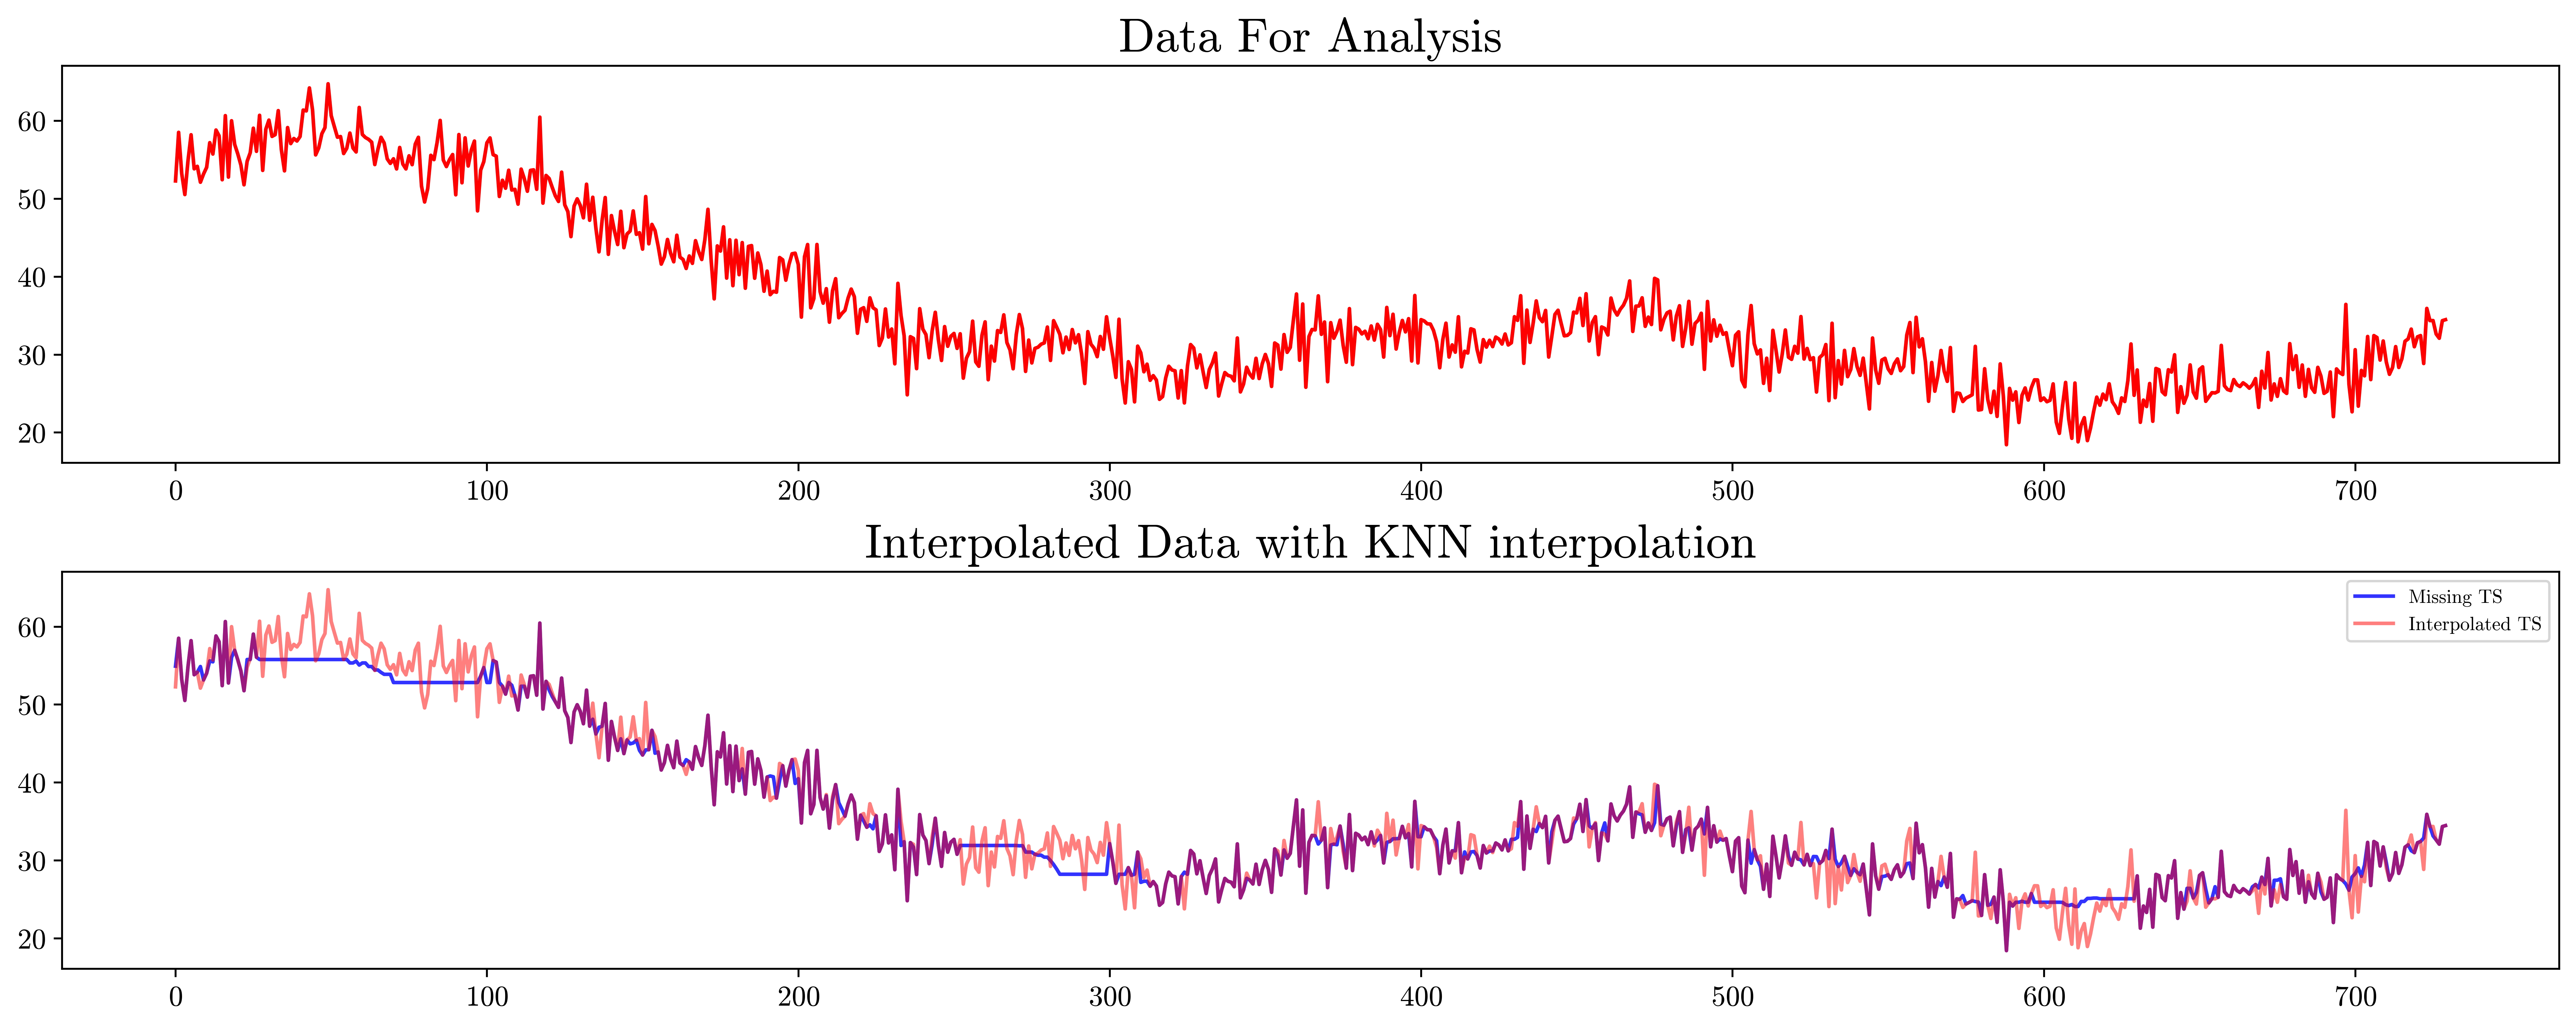

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.title('Data For Analysis')
plt.plot(all_data[0],'r-')
plt.subplot(2,1,2)
missing_data=create_nans_selectively(all_data,perc=0.4)
plt.title('Interpolated Data with KNN interpolation')
#plt.plot(missing_data,'g--',linewidth=1.5)
plt.plot(knn_interpolation(missing_data)[0],'b-',alpha=0.8)
plt.plot(all_data[0],'r-',alpha=0.5)
plt.legend(['Missing TS','Interpolated TS','Original Data'])
plt.tight_layout(pad=1)
plt.show()

## Clustering 

In [9]:
cluster_orginal_data_results=kMeans_timeseries(all_data,data_labels,times_init_centroid=2)

-------------------------------------------
Confusion Matrix:
[[15  0  0  0]
 [ 0 12  0  0]
 [ 1  0 10  0]
 [ 0  0  0 12]]
Normalized Mutual Information (NMI): 0.948439980091274
Adjusted Rand Index (ARI): 0.9441228148599559
F1 Score: 0.9800307219662059


In [10]:
missing_data=create_nans_selectively(all_data,perc=0.65)
imputed_data=knn_interpolation(missing_data)
print('RMSE:',rmse_data(all_data[0],imputed_data[0]))
print(  find_score_data(missing_data))

RMSE: 2.682415445343744
0.300226


In [11]:
cluster_orginal_data_results=kMeans_timeseries(imputed_data,data_labels,times_init_centroid=2)

-------------------------------------------
Confusion Matrix:
[[15  0  0  0]
 [ 1 11  0  0]
 [ 1  0 10  0]
 [ 0  0  0 12]]
Normalized Mutual Information (NMI): 0.8954889491770887
Adjusted Rand Index (ARI): 0.8844511520419677
F1 Score: 0.9616006728778468


## Loop clustering
---
* We have our custom scoring mechanism
* We create synthetic NaNs in the dataset and impute them
* Try clustering imputed data. If our imputed data clustering has low score our clustering should prolly be bad
* Creating NaNs in 1 ways and using KNN and Linear Interpolation

In [12]:
from tqdm.notebook import tqdm

df_results_series=pd.DataFrame()
df_results_clustering=pd.DataFrame({'NaNs':[],'Score_20':[],'Score_80':[],'F1_Score':[],'NMI':[],'ARI':[],'Interpolation':[],'NaN_Method':[]})

percentage_missing=np.arange(0.1,0.95,0.1)
threshold_list=np.arange(0.2,0.9,0.6)
num_times_loop=3


data=np.array(all_data) # For easier notation replace data with all_data
pbar=tqdm(total=len(percentage_missing)*num_times_loop*4)

for na_perc in percentage_missing:
    for _ in range(num_times_loop):
        data_missing=create_nans_selectively(data,perc=na_perc)
        data_imputed=knn_interpolation(data_missing)
        x=kMeans_timeseries(pd.DataFrame(data_imputed),data_labels,to_plot=False,to_print=False,times_init_centroid=2)
        x['Clustering']='KMeans'
        x['interpolation']=['KNN' for i in range(len(x))]
        x['nans_created']='Selective'
        x['nan_percentage']=na_perc
        for t_val in threshold_list:
            x['Scores_'+str(round(t_val,2)*100)]=find_score_data(data_missing,threshold=t_val,return_avg=False)
        df_results_series=pd.concat([df_results_series, x])


        f1=f1_score(x['labels'],x['Predicted_labels'],average='macro')
        nmi=normalized_mutual_info_score(x['labels'],x['Predicted_labels'])
        ri=adjusted_rand_score(x['labels'],x['Predicted_labels'])
        sc=[]
        for tval in threshold_list:
            sc.append(find_score_data(data_missing,threshold=tval/100,return_avg=True))
        df_results_clustering.loc[len(df_results_clustering)]=[na_perc,sc[0],sc[1],f1,nmi,ri,'KNN','Selective']
        pbar.update(1)

    for _ in range(num_times_loop):
        data_missing=create_nans_consecutively(data,perc=na_perc)
        data_imputed=knn_interpolation(data_missing)
        x=kMeans_timeseries(pd.DataFrame(data_imputed),data_labels,to_plot=False,to_print=False,times_init_centroid=2)
        x['Clustering']='KMeans'
        x['interpolation']=['KNN' for i in range(len(x))]
        x['nans_created']='Consecutively'
        x['nan_percentage']=na_perc
        for t_val in threshold_list:
            x['Scores_'+str(round(t_val,2)*100)]=find_score_data(data_missing,threshold=t_val,return_avg=False)
        df_results_series=pd.concat([df_results_series, x])


        f1=f1_score(x['labels'],x['Predicted_labels'],average='macro')
        nmi=normalized_mutual_info_score(x['labels'],x['Predicted_labels'])
        ri=adjusted_rand_score(x['labels'],x['Predicted_labels'])
        sc=[]
        for tval in threshold_list:
            sc.append(find_score_data(data_missing,threshold=tval/100,return_avg=True))
        df_results_clustering.loc[len(df_results_clustering)]=[na_perc,sc[0],sc[1],f1,nmi,ri,'KNN','Consecutively']
        pbar.update(1)
    
    for _ in range(num_times_loop):
        data_missing=create_nans_selectively(data,perc=na_perc)
        data_imputed=linear_interpolation(data_missing)
        x=kMeans_timeseries(pd.DataFrame(data_imputed),data_labels,to_plot=False,to_print=False,times_init_centroid=2)
        x['Clustering']='K Means'
        x['interpolation']=['Linear Interpolation' for i in range(len(x))]
        x['nans_created']='Selective'
        x['nan_percentage']=na_perc
        for t_val in threshold_list:
            x['Scores_'+str(round(t_val,2)*100)]=find_score_data(data_missing,threshold=t_val,return_avg=False)
        df_results_series=pd.concat([df_results_series, x])

        f1=f1_score(x['labels'],x['Predicted_labels'],average='macro')
        nmi=normalized_mutual_info_score(x['labels'],x['Predicted_labels'])
        ri=adjusted_rand_score(x['labels'],x['Predicted_labels'])
        sc=[]
        for tval in threshold_list:
            sc.append(find_score_data(data_missing,threshold=tval/100,return_avg=True))
        df_results_clustering.loc[len(df_results_clustering)]=[na_perc,sc[0],sc[1],f1,nmi,ri,'Linear','Selective']
        pbar.update(1)

    for _ in range(num_times_loop):
        data_missing=create_nans_consecutively(data,perc=na_perc)
        data_imputed=linear_interpolation(data_missing)
        x=kMeans_timeseries(pd.DataFrame(data_imputed),data_labels,to_plot=False,to_print=False,times_init_centroid=2)
        x['Clustering']='K Means'
        x['interpolation']=['Linear Interpolation' for i in range(len(x))]
        x['nans_created']='Consecutively'
        x['nan_percentage']=na_perc
        for t_val in threshold_list:
            x['Scores_'+str(round(t_val,2)*100)]=find_score_data(data_missing,threshold=t_val,return_avg=False)
        df_results_series=pd.concat([df_results_series, x])

        f1=f1_score(x['labels'],x['Predicted_labels'],average='macro')
        nmi=normalized_mutual_info_score(x['labels'],x['Predicted_labels'])
        ri=adjusted_rand_score(x['labels'],x['Predicted_labels'])
        sc=[]
        for tval in threshold_list:
            sc.append(find_score_data(data_missing,threshold=tval/100,return_avg=True))
        df_results_clustering.loc[len(df_results_clustering)]=[na_perc,sc[0],sc[1],f1,nmi,ri,'Linear','Consecutively']
        pbar.update(1)

df_results_clustering.to_csv(f'{"D:/BTP/Results/"}clustering_results_selective_NaNs.csv',index=False)
df_results_series.to_csv(f'{"D:/BTP/Results/"}series_clustering_results_selective_NaNs.csv',index=False)

  0%|          | 0/108 [00:00<?, ?it/s]

In [2]:
df_results_clustering=pd.read_csv(f'{"D:/BTP/Results/"}clustering_results_selective_NaNs.csv')
df_results_series=pd.read_csv(f'{"D:/BTP/Results/"}series_clustering_results_selective_NaNs.csv')

df_results_clustering

NaNs  Score_20  Score_80  F1_Score       NMI       ARI Interpolation  \
0     0.1  0.897736  0.897736  1.000000  1.000000  1.000000           KNN   
1     0.1  0.897886  0.897886  0.980031  0.948440  0.944123           KNN   
2     0.1  0.897730  0.897730  1.000000  1.000000  1.000000           KNN   
3     0.1  0.810000  0.810000  0.943002  0.865157  0.836072           KNN   
4     0.1  0.810000  0.810000  1.000000  1.000000  1.000000           KNN   
..    ...       ...       ...       ...       ...       ...           ...   
103   0.9  0.098504  0.098284  0.845994  0.756123  0.638101        Linear   
104   0.9  0.098530  0.098298  0.808779  0.714202  0.610997        Linear   
105   0.9  0.010000  0.010000  0.961429  0.896743  0.887852        Linear   
106   0.9  0.010000  0.010000  0.778095  0.691317  0.552557        Linear   
107   0.9  0.010000  0.010000  0.981379  0.947861  0.941408        Linear   

        NaN_Method  
0        Selective  
1        Selective  
2        Selective  
3    Consecutively  
4    Consecutively  
..             ...  
103      Selective  
104      Selective  
105  Consecutively  
106  Consecutively  
107  Consecutively  

[108 rows x 8 columns]

In [20]:
x=df_results_clustering[(df_results_clustering['Interpolation']=='Linear')&(df_results_clustering['NaN_Method']=='Selective')]

In [21]:
x.sample(5).sort_values('NaNs').reset_index(drop=True)

NaNs  Score_20  Score_80  F1_Score       NMI       ARI Interpolation  \
0   0.2  0.797664  0.797664  0.980031  0.948440  0.944123        Linear   
1   0.3  0.697916  0.697916  1.000000  1.000000  1.000000        Linear   
2   0.5  0.498048  0.498048  0.924603  0.841108  0.789162        Linear   
3   0.6  0.398058  0.397420  1.000000  1.000000  1.000000        Linear   
4   0.9  0.098530  0.098298  0.808779  0.714202  0.610997        Linear   

  NaN_Method  
0  Selective  
1  Selective  
2  Selective  
3  Selective  
4  Selective

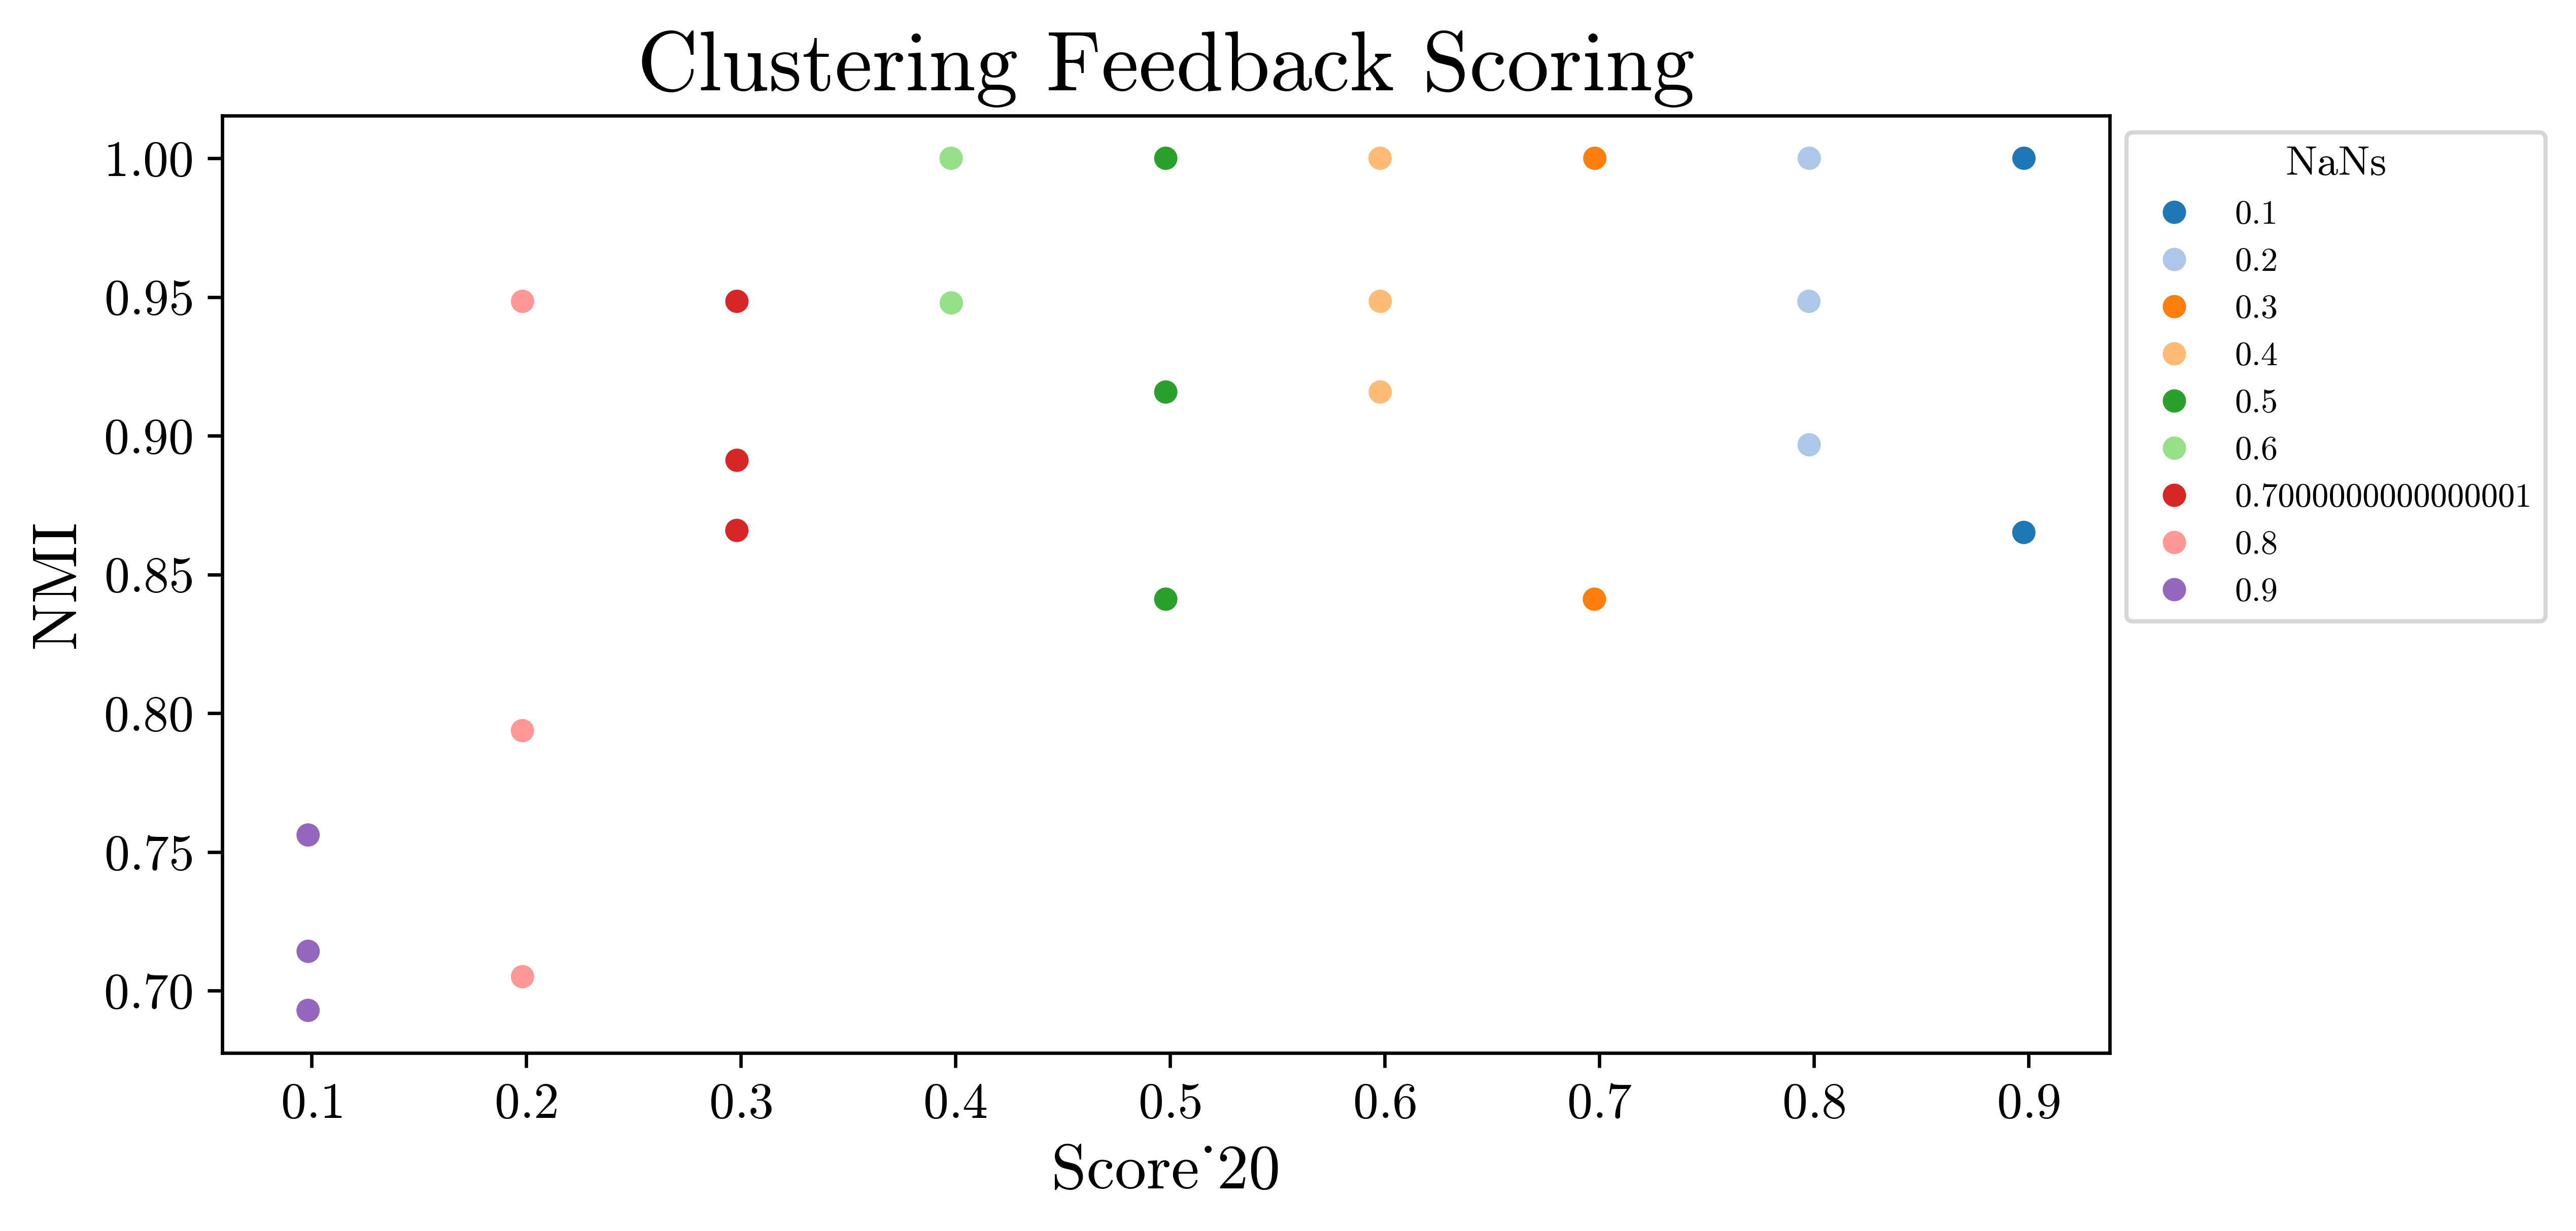

In [22]:
sns.scatterplot(data=x,x='Score_20',y='NMI',hue='NaNs',palette='tab20')
plt.legend(title='NaNs',title_fontsize=10,bbox_to_anchor=(1, 1))
plt.title('Clustering Feedback Scoring')
plt.ylabel('NMI')
plt.xlabel('Score_20')
plt.show()